<a href="https://colab.research.google.com/github/SunkaraboinaPraveenKumar/Machine_Learning_Projects/blob/main/AI_Agent_Bot_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install langchain langchain_groq langchain_community langgraph rizaio graphviz

In [32]:
import os
from google.colab import userdata

groq_api_key=userdata.get('groq_api_key')
os.environ['RIZA_API_KEY']=userdata.get('RIZA_API_KEY')
os.environ['TAVILY_API_KEY']=userdata.get('TAVILY_API_KEY')

In [33]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.riza.command import ExecPython

In [34]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    groq_api_key=groq_api_key,
    model_name="llama-3.2-90b-vision-preview"
)

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7e30b9e92020>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7e30b9e934f0>, model_name='llama-3.2-90b-vision-preview', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [35]:
llm.invoke('Hi, How are You?')

AIMessage(content="I'm just a computer program, so I don't have feelings, but thanks for asking. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 41, 'total_tokens': 68, 'completion_time': 0.113653845, 'prompt_time': 0.005347001, 'queue_time': 0.056179279000000006, 'total_time': 0.119000846}, 'model_name': 'llama-3.2-90b-vision-preview', 'system_fingerprint': 'fp_07b97e5459', 'finish_reason': 'stop', 'logprobs': None}, id='run-b81c4e2a-3ee2-46cd-a2a5-0c968dc40b85-0', usage_metadata={'input_tokens': 41, 'output_tokens': 27, 'total_tokens': 68})

In [36]:
tools_tavily=TavilySearchResults(max_results=3)
tool_code_interpreter=ExecPython()
tools=[tools_tavily, tool_code_interpreter]

In [37]:
llm_with_tools = llm.bind_tools(tools=tools)

In [38]:
llm_with_tools.invoke('Give me current Trending events in USA?')

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r33d', 'function': {'arguments': '{"query": "current trending events in USA"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 416, 'total_tokens': 438, 'completion_time': 0.131276946, 'prompt_time': 0.069910363, 'queue_time': 0.09841129500000001, 'total_time': 0.201187309}, 'model_name': 'llama-3.2-90b-vision-preview', 'system_fingerprint': 'fp_07b97e5459', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-341f5a7e-7947-488e-b43d-8a8ae14e5702-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current trending events in USA'}, 'id': 'call_r33d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 416, 'output_tokens': 22, 'total_tokens': 438})

In [39]:
response = llm.invoke('''
### What is the output of print(['a']+[2])
''')

if hasattr(response, 'content'):
  print('AI response Content:', response.content)
else:
  print('AI Response:',response)

AI response Content: The output of `print(['a'] + [2])` will be:

```
['a', 2]
```

In Python, when you use the `+` operator with lists, it concatenates the two lists into a new list. So, `['a'] + [2]` creates a new list that contains all the elements from the first list (`['a']`) followed by all the elements from the second list (`[2]`).


In [40]:
class State(TypedDict):
  messages:Annotated[list, add_messages]

In [41]:
# Define a chatbot function that takes a state as input and returns a new state with updated messages
def chatbot(state: State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]} ## Invoke the LLM on the Input messages

In [42]:
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot",chatbot)
tool_node=ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools","chatbot")
graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile()

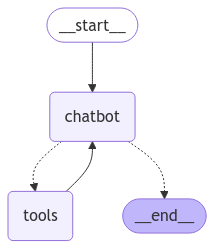

In [43]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  display(Image(graph.get_graph().draw_graphviz_png()))

In [44]:
def stream_graph_updates(user_input:str):
  """
  Streams updates from the compiled graph based on user input.

  Args:
    user_input (str): The user's input message.

  Prints:
    str: The assistant's response message.
  """

  initial_state = {"messages":[("user",user_input)]}

  for event in graph.stream(initial_state):
    for value in event.values():
      print("Assistant:", value["messages"][-1].content)

In [45]:
while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit","exit","q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input)
  except Exception as e:
    print("Exceptions occured during processing:",e)
    stream_graph_updates(user_input)
    break

User: What is Latest News in Tirupati?
Assistant: 
Assistant: [{"url": "https://www.youtube.com/watch?v=-nrvDJh-5eo", "content": "At least 6 persons lost their lives and several others sustained injuries after a stampede broke out at the Tirupati Temple on January 08."}, {"url": "https://www.livemint.com/news/india/tirupati-stampede-news-live-updates-tirumala-balaji-temple-ttd-dead-injured-andhra-pradesh-cm-naidu-pawan-kalyan-11736392283938.html", "content": "Tirupati Stampede News LIVE: At least six people were killed in a temple stampede in Tirumala Tirupati. Andhra Pradesh Chief Minister"}, {"url": "https://www.hindustantimes.com/india-news/tirupati-stampede-live-updates-deaths-injuries-vaikunta-dwara-darshanam-ticket-andhra-pradesh-101736355724734.html", "content": "Tirupati stampede live updates: At least six people were killed and several others injured after a stampede broke out near Tirupati's Vishnu"}]
Assistant: There has been a recent stampede at the Tirupati Temple, which h

In [46]:
user_input="run the python code to find permutations present in 'aabc' sequence?"

events = graph.stream(
    {"messages":[("user",user_input)]}, stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

run the python code to find permutations present in 'aabc' sequence?
================================== Ai Message ==================================
Tool Calls:
  riza_exec_python (call_62vn)
 Call ID: call_62vn
  Args:
    code: import itertools
print(list(itertools.permutations('aabc')))
================================= Tool Message =================================
Name: riza_exec_python

[('a', 'a', 'b', 'c'), ('a', 'a', 'c', 'b'), ('a', 'b', 'a', 'c'), ('a', 'b', 'c', 'a'), ('a', 'c', 'a', 'b'), ('a', 'c', 'b', 'a'), ('a', 'a', 'b', 'c'), ('a', 'a', 'c', 'b'), ('a', 'b', 'a', 'c'), ('a', 'b', 'c', 'a'), ('a', 'c', 'a', 'b'), ('a', 'c', 'b', 'a'), ('b', 'a', 'a', 'c'), ('b', 'a', 'c', 'a'), ('b', 'a', 'a', 'c'), ('b', 'a', 'c', 'a'), ('b', 'c', 'a', 'a'), ('b', 'c', 'a', 'a'), ('c', 'a', 'a', 'b'), ('c', 'a', 'b', 'a'), ('c', 'a', 'a', 'b'), ('c', 'a', 'b', 'a'), ('c', 'b', 'a', 'a'), ('c', 'b', 'a'